# Prediction Modeling
- 데이터 분석 결과를 기반으로 예측 모델링 실시
- 다중 분류(Multi-class classification) 문제

## 배경

- 코로나 바이러스(Covid19)로 인해 수많은 입원환자가 발생하여 여러 병원들의 병상 부족 문제 발생

## 목적

- 환자의 여러가지 특성 데이터를 기반으로 입원 환자 개개인의 예상 재원일수를 예측하여 해당 환자에게 최적화된 치료법을 수행하고 의료진과 병원 방문객들의 집단 감염을 막기 위함

## 가설

- 환자기 입원한 병원의 유형, 입원 환자의 질환 종류, 병실 유형, 병실 시설 유형, 환자동반 방문객 수, 총 5개의 변수가 재원일수에 영향을 미칠 것으로 판단
    * 특히 ``환자 동반 방문객 수는 재원일수와 0.5 라는 양의 상관계수``를 보임

## 데이터 로드

In [88]:
import pandas as pd
import numpy as np
import os
os.chdir('/Users/younghun/Desktop/gitrepo/data/healthcare')
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
print("Train shape: ", train.shape)
print("Test shape: ", test.shape)

Train shape:  (318438, 18)
Test shape:  (137057, 17)


In [89]:
# 중복 데이터 존재 여부 확인 -> 중복 데이터는 없음
train.duplicated().sum()

0

## 종속변수에 대한 이해

- 종속변수 : Stay(재원일수)
    * 범주형 변수(범위화 되어 있음)
    * 클래스 개수 : 11개
    * 종속변수 분포 : 클래스 불균형 존재

In [90]:
# 종속변수에 대한 간단한 탐색
print("# 종속변수 Level 개수: ", train['Stay'].nunique(),'\n')
print("# 종속변수 Level 종류: ", train['Stay'].unique(),'\n')
print("# 종속변수 Level 개수 분포\n", train['Stay'].value_counts())

# 종속변수 Level 개수:  11 

# 종속변수 Level 종류:  ['0-10' '41-50' '31-40' '11-20' '51-60' '21-30' '71-80'
 'More than 100 Days' '81-90' '61-70' '91-100'] 

# 종속변수 Level 개수 분포
 21-30                 87491
11-20                 78139
31-40                 55159
51-60                 35018
0-10                  23604
41-50                 11743
71-80                 10254
More than 100 Days     6683
81-90                  4838
91-100                 2765
61-70                  2744
Name: Stay, dtype: int64


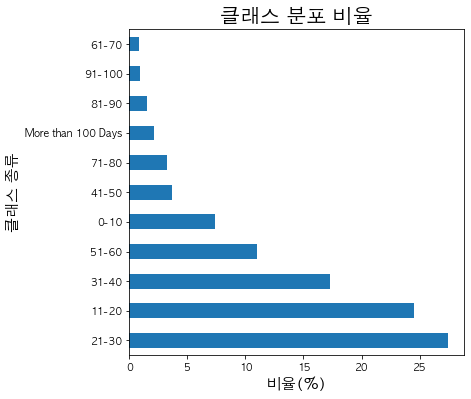

In [91]:
# 클래스 분포 비율로 나타낸 후 시각화
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
plt.figure(figsize=(6,6))

class_ratio = np.round((train['Stay'].value_counts() / train['Stay'].value_counts().values.sum()) * 100, 2)
class_ratio.plot.barh()
plt.title("클래스 분포 비율", fontsize=20)
plt.xlabel("비율(%)", fontsize=15)
plt.ylabel("클래스 종류", fontsize=15)
plt.show()

**클래스 불균형 해결 방법**

- ``언더샘플링``
    - 언더 샘플링으로 데이터 개수를 줄이기에는 원본 데이터가 많은 편이 아니기 떄문에 부적절로 판단<br><br>

- ``오버샘플링``
    - 클래스 불균형이 심한 상태로 오버 샘플링을 해주어야 한다.(단 Train데이터에서만)
    - 그리고 오버 샘플링을 수행한 후 교차검증을 수행해주어야 한다.
        * 왜냐하면 클래스 불균형 상태에서 모델이 학습한 후 도출되는 높은 성능은 어떤 데이터가 들어올지 모르는 테스트 데이터에서 **과대적합 문제**가 발생할 수 있기 때문이다. 따라서 최대한 ``어떤 데이터가 들어왔을 때도 잘 예측할 수 있도록 학습하기 위해 클래스 불균형을 해소한 후 교차검증을 적용``시켜야 한다.
<br><br>   
- ``Cost-sensitive Learning``
    - 학습 시 ``클래스 개수가 적은 데이터쪽으로 편향되어 학습``하도록 하는 방법
    - 클래스 개수에 따라 자동으로 balanced인자 넣어주어서 가중치 부여
    - 클래스 개수에 따른 weight를 직접 커스터마이징해서 부여

## 독립변수에 대한 이해

- 수치형 변수, 범주형 변수 구분
- 독립변수로부터 파생변수 생성

In [92]:
# 수치형 변수, 범주형 변수 구분
num_cols = ['Available Extra Rooms in Hospital','Visitors with Patient','Admission_Deposit']
num_df = train[num_cols]
cate_df = train.drop(num_cols, axis=1)
category_cols = cate_df.columns.tolist()
category_cols.remove('Stay')

print("# 수치형 변수 :", num_df.columns.tolist(),'\n')
print("# 범주형 변수 :\n", category_cols)

# 수치형 변수 : ['Available Extra Rooms in Hospital', 'Visitors with Patient', 'Admission_Deposit'] 

# 범주형 변수 :
 ['case_id', 'Hospital_code', 'Hospital_type_code', 'City_Code_Hospital', 'Hospital_region_code', 'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade', 'patientid', 'City_Code_Patient', 'Type of Admission', 'Severity of Illness', 'Age']


### 수치형 변수

- 데이터 분석 결과를 기반으로 하여<br><br>
    * Available Extra Rooms in Hospital(여분 병실수)
        - 해당 변수는 종속변수와 관계가 없는 것으로 도출
        - 따라서 **변수 삭제 또는 파생변수 생성**에 이용<br><br>
    * Visitors with Patient(환자 동반 방문객 수)
        - 해당 변수는 종속변수와 양의 상관관계를 보이며 깊은 관계가 있는 것으로 도출
        - 따라서 **이상치 관찰 후 스케일링 적용 여부 판단 후 변수 그대로 사용**<br><br>
    * Admission_Deposit(입원 보증금)
        - 해당 변수는 종속변수와 관계가 없는 것으로 도출
        - 따라서 **변수 삭제 또는 파생변수 생성**에 이용

#### 여분 병실수 변수

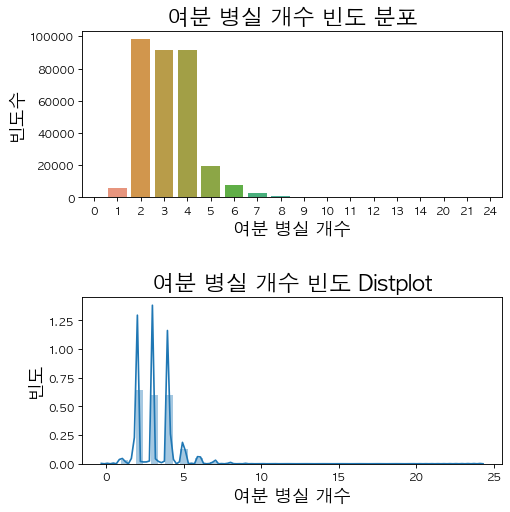

In [93]:
# 여분 병실수 변수 분포(countplot & distplot)
import seaborn as sns

fig, axes = plt.subplots(figsize=(6,6), ncols=1, nrows=2, dpi=80)
plt.tight_layout()
plt.subplots_adjust(hspace=0.6)
sns.countplot(x=num_df['Available Extra Rooms in Hospital'], ax=axes[0])
sns.distplot(num_df['Available Extra Rooms in Hospital'], ax=axes[1])

axes[0].set_title("여분 병실 개수 빈도 분포", fontsize=20)
axes[0].set_xlabel("여분 병실 개수", fontsize=16)
axes[0].set_ylabel("빈도수", fontsize=16)
axes[1].set_title("여분 병실 개수 빈도 Distplot", fontsize=20)
axes[1].set_xlabel("여분 병실 개수", fontsize=16)
axes[1].set_ylabel("빈도", fontsize=16)
plt.show()

- 정규분포 비슷한 형태를 띔
- 여분 병실 개수가 이산형 변수이기 떄문에 확률밀도함수(Distplot)를 그릴 필요는 없음
- boxplot 그려보기

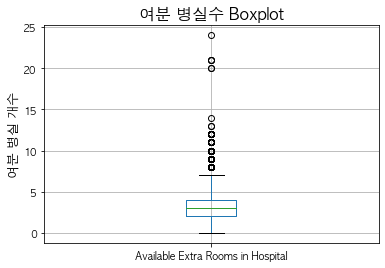

In [94]:
num_df[['Available Extra Rooms in Hospital']].boxplot()
plt.title("여분 병실수 Boxplot", fontsize=16)
plt.ylabel("여분 병실 개수", fontsize=13)
plt.show()

- 이상치가 존재. 하지만 데이터 분석 결과, 여분 병실수와 재원일수 간에는 상관관계를 보이지 않음.
- 따라서 Scaling을 통해 분포 변환시키기

#### 환자 동반 방문객 수

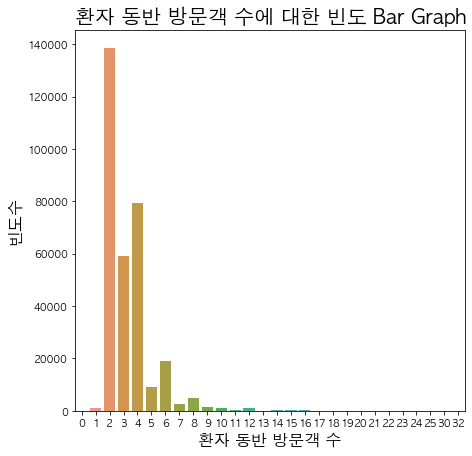

In [95]:
# 환자 동반 방문객 수(countplot, distplot)
# 환자 동반 방문객 수도 이산형(Discrete) 변수이기 때문에 확률밀도함수를 그리지 않고 countplot으로 정규분포형태 확인!
plt.figure(figsize=(7,7))
sns.countplot(num_df['Visitors with Patient'])
plt.title("환자 동반 방문객 수에 대한 빈도 Bar Graph", fontsize=20)
plt.xlabel("환자 동반 방문객 수", fontsize=16)
plt.ylabel("빈도수", fontsize=16)
plt.show()

In [96]:
# 방문객 수(이산형 변수) unique한 값 개수 
num_df['Visitors with Patient'].nunique()

28

- 해당 변수는 종속변수에 큰 영향을 미치기 떄문에 사용할 모델에 따른 분포 변환을 수행해주어야 함
    - Tree기반 알고리즘
        * categorical, ordinal 변수가 더 적합하기 떄문에 별도의 변환 수행하지 않기
    - 선형성 기반 알고리즘
        * 해당 변수 분포를 정규분포 형태로 바꾸어 주어야 예측 모델에 더 적합할 것이므로 변환 수행해주기
        <br><br>
- 하지만 반드시 정규 분포형태로 절대적으로 바꾸어야 하는 이유는 없으므로 해당 변수 원본 그대로 사용
    * 변형을 해주기 위해서 변수값의 의미에 따라 카테고리형으로 binning해주자.
    * 해당 이산형 변수 level값 종류가 28개이므로 그 이하의 개수로 범위(range)화 시켜줘서 binning시키기!


참고 : <Continuous 변수를 Discrete 변수로 바꾸어줌으로써 정규분포로 변환시키기도 가능>
- uniform/Quantile/Clustered 방법이 존재
- <a href='https://machinelearningmastery.com/discretization-transforms-for-machine-learning/'>레퍼런스 링크</a> 참조

In [97]:
# 방문객 수를 range화 시켜서 카테고리형 변수로 binning시키기
# binning시키는 기준 파악 위해서 기술통계량 살펴보기
num_df['Visitors with Patient'].describe()

count    318438.000000
mean          3.284099
std           1.764061
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          32.000000
Name: Visitors with Patient, dtype: float64

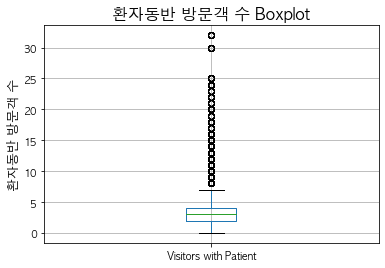

In [98]:
num_df[['Visitors with Patient']].boxplot()
plt.title("환자동반 방문객 수 Boxplot", fontsize=16)
plt.ylabel("환자동반 방문객 수", fontsize=13)
plt.show()

- 이상치가 많이 존재하며 이상치에 민감하지 않은 Robust scaling한 파생변수 생성
    * 하지만 해당 변수가 2라는 value에 집중되어 있으므로 스케일링 후가 더 부정적일 수 있으므로 추후 제거 여부 판단해야 함
- 해당변수를 binning시키기 위해 평균값과 3사분위값이 3, 4로 얼마 차이나지 않는 것으로 보아 3분위수 보다 크고 작은 기준으로 binary 범주형 파생변수 생성하기

In [99]:
# Robust scaling 파생변수
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings(action='ignore')
scaler = RobustScaler()
num_df['Visitors_Robust'] = scaler.fit_transform(num_df[['Visitors with Patient']])

In [100]:
# 방문객 수 중앙값인 3을 기준으로 그 값보다 크면 1, 작거나 같으면 0으로 원-핫 인코딩
Q3_visitor = num_df['Visitors with Patient'].quantile(0.75)
num_df.loc[num_df['Visitors with Patient'] > Q3_visitor, 'Visitors_Q3_ohe'] = 1
num_df.loc[num_df['Visitors with Patient'] <= Q3_visitor, 'Visitors_Q3_ohe'] = 0

#### 입원 보증금

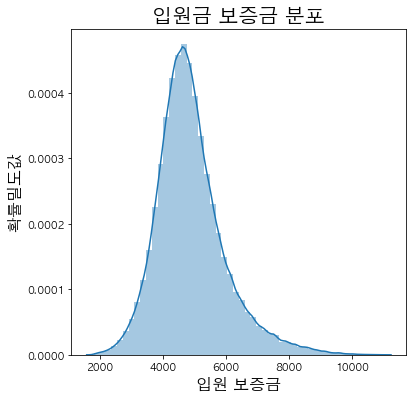

In [101]:
# 입원 보증금(연속형 변수) 확률밀도함수 분포 살펴보기
plt.figure(figsize=(6,6))
sns.distplot(num_df['Admission_Deposit'])
plt.title("입원금 보증금 분포", fontsize=20)
plt.xlabel("입원 보증금", fontsize=16)
plt.ylabel("확률밀도값", fontsize=16)
plt.show()

- 입원 보증금은 정규분포형태를 띄며 별다른 변형 취해주지 않아도 됨.
- 하지만 ``입원 보증금은 종속변수와는 거의 독립적인 관계이긴 함.``
- 따라서
    * 변수값 그대로 사용
    * 이상치를 고려한 Robust scaling후 사용
    * 보증금 값들을 기술통계량의 특정 대푯값을 기준으로 range를 나누어 binary 변수로 변환 
    * 연속형 값인 보증금 값들을 이산형 값들로 Discretization한 파생변수 생성

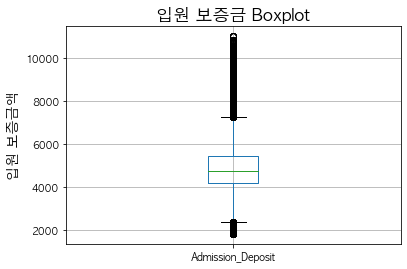

In [102]:
num_df[['Admission_Deposit']].boxplot()
plt.title("입원 보증금 Boxplot", fontsize=17)
plt.ylabel("입원 보증금액", fontsize=14)
plt.show()

In [103]:
# 보증금 값 기술통계량
num_df['Admission_Deposit'].describe()

count    318438.000000
mean       4880.749392
std        1086.776254
min        1800.000000
25%        4186.000000
50%        4741.000000
75%        5409.000000
max       11008.000000
Name: Admission_Deposit, dtype: float64

In [104]:
# 이상치가 많으니 이상치에 민감하지 않은 Robust scaling한 파생변수 생성
scaler = RobustScaler()
num_df['Admission_Deposit_Robust'] = scaler.fit_transform(num_df[['Admission_Deposit']])

In [105]:
# 3사분위수보다 큰 데이터 몇개인지 살펴보기
num_df[num_df['Admission_Deposit'] > num_df['Admission_Deposit'].quantile(0.75)].shape[0]

79544

In [106]:
# 3사분위수보다 크면 1, 작거나 같으면 0으로 binary 변수 생성
Q3_deposit = num_df['Admission_Deposit'].quantile(0.75)
num_df.loc[num_df['Admission_Deposit'] > Q3_deposit, 'Admission_Deposit_Q3_ohe'] = 1
num_df.loc[num_df['Admission_Deposit'] <= Q3_deposit, 'Admission_Deposit_Q3_ohe'] = 0

In [107]:
# 이산형변수로 Discretization한 파생변수 생성
from sklearn.preprocessing import KBinsDiscretizer
# Quantile을 기준으로 설정(이 때, n_bins값은 관측치 개수 이하로 설정해야함)
kbins = KBinsDiscretizer(n_bins=10, encode='ordinal',
                        strategy='quantile')
num_df['Admission_Deposit_Discretization'] = kbins.fit_transform(num_df[['Admission_Deposit']])

In [108]:
# 이산형 변수로 변환한 level값들 개수
num_df['Admission_Deposit_Discretization'].value_counts()

2.0    31929
6.0    31889
8.0    31875
4.0    31870
5.0    31869
9.0    31860
7.0    31809
0.0    31806
1.0    31780
3.0    31751
Name: Admission_Deposit_Discretization, dtype: int64

### 범주형 변수

- 범주형 변수 중 ``case_id``는 입원 고유한 id이므로 **삭제**
- 범주형 변수 중 ``Hospital_code``도 병원의 고유한 id이며 **삭제**
- 범주형 변수 중 ``patientid``도 환자의 고유한 id이며 **삭제**
<br><br>
- **모든 명목형 변수의 기본적인 원-핫 인코딩은 메모리 이슈로 인해 범주형 변수 최종단계에서 모두 수행**

In [109]:
del cate_df['case_id']

In [110]:
del cate_df['Hospital_code']

In [111]:
del cate_df['patientid']

#### Hospital_type_code(병원 유형 코드)
- 데이터 분석 결과, 해당 변수로 추출할 수 있었던 인사이트는 ``a병원이 전체적으로 가장 많이 존재하는 병원이며 큰 재단의 병원일 것으로 추론``
- 기본적으로 병원 유형 level값을 ``원-핫 인코딩`` 수행
- 추가적으로 ``a병원 유형 여부에 대한 binary 파생변수 생성``시도 

In [112]:
# a병원 유형 여부에 대한 binary 파생변수 생성
cate_df.loc[cate_df['Hospital_type_code']=='a', 'Hospital_type_a_binary'] = 1
cate_df.loc[cate_df['Hospital_type_code']!='a', 'Hospital_type_a_binary'] = 0

#### Hospital_region_code(병원 위치한 지역 코드)
- 데이터 분석 결과, X,Y 지역에 대부분의 인구가 살고, Z지역에는 상대적으로 소수의 인구가 거주
- 또한 재원일수와의 독립성 검정 후 관계가 있으며 모자이크 플랏 시각화해 본 결과, 비율의 차이가 존재
- 따라서 Hospital_region_code 변수에 대해 ``원-핫 인코딩`` 수행

#### City_Code_Hospital(병원 위치한 도시 코드)
- 데이터 분석 결과, 종속변수와 독립성 검정 후 관계가 있으며, 비율의 차이가 존재
- 따라서, ``원-핫 인코딩`` 수행

#### Department(입원 환자 담당 부서)
- 데이터 분석 결과, 부서 level별로 ``원-핫 인코딩``수행

#### Ward_Type(병실 유형), Ward_Facility_Code(병실 시설 코드)
- 데이터 분석 결과, 종속변수와 독립성 검정 후 관계가 있으며, 비율의 차이가 존재
- 따라서, ``원-핫 인코딩`` 수행

#### Bed Grade(침실 등급)
- 데이터 분석 결과, 종속변수와 관계가 독립.
- 결측치가 113개 존재하며, Ordinal 변수이기 때문에 Label encoding해도 되지만 종속변수와의 관계와 결측치 존재 여부를 고려하여 해당 변수는 ``삭제``

In [113]:
del cate_df['Bed Grade']

#### City_Code_Patient(환자 거주 도시코드)
- 우선 결측치가 4532개 존재
- 해당 변수가 종속변수와의 관계는 영향을 미치지 못하나, ``결측치가 주로 발생하는 병원이 a병원임을 도출``
- 따라서 예측 모델링에는 필요한 변수가 아니기 때문에 해당 변수 삭제

In [114]:
del cate_df['City_Code_Patient']

#### Type of Admission(입원 유형), Severity of Illness(질병 심각성)
- 데이터 분석 결과, 두 변수는 종속변수와 독립적인 관계로 도출
- 따라서, 해당 변수들 ``원-핫 인코딩`` 수행하지만 ``추후 feature selection과정에서 삭제 가능성 농후``

#### Age(연령대)
- 데이터 분석 결과, 종속변수와의 켄달 상관계수값이 ``0.07``로 도출
- 서열 척도이기 때문에 우선 ``Label 인코딩`` 실시 후 ``추후 feature selection과정에서 삭제 가능성 존재``

In [115]:
# Age 레이블 인코딩
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

cate_df['Age'] = encoder.fit_transform(cate_df['Age'])

#### 범주형 변수 '원-핫 인코딩'

In [116]:
# 한 변수씩 원-핫 인코딩한 데이터프레임 dictionary에 담기
cols = ['Hospital_type_code','Hospital_region_code','City_Code_Hospital','Department','Ward_Type','Ward_Facility_Code',
'Type of Admission','Severity of Illness']

df_dict = {}
for col in cols:
    df_dict[col] = pd.get_dummies(cate_df[col], prefix=col)

In [117]:
# dictionary에 담긴 데이터 프레임 하나의 데이터프레임으로 모두 합치기
ohe_df = pd.DataFrame()

for k in df_dict.keys():
    ohe_df = pd.concat([ohe_df, df_dict[k]], axis=1)

In [118]:
# 위에서 만들었던 Hospital_type_a_binary 파생변수도 concat
ohe_df = pd.concat([ohe_df, cate_df[['Hospital_type_a_binary']]], axis=1)

### 수치형 변수 + 인코딩한 범주형 변수 concat

- 수치+범주형 변수 합치고 종속변수 Label인코딩시킨 후 최종 feature 데이터 완성

In [119]:
# 수치+범주형 변수 concat
feature_df = pd.concat([ohe_df, num_df], axis=1)
feature_df.shape

(318438, 53)

In [120]:
# 종속변수 Label encoding 시킨 array 변수 데이터프레임(feature_df)에 추가
encoder = LabelEncoder()
feature_df['Y_Stay'] = encoder.fit_transform(train['Stay'])

In [122]:
# 최종 데이터 shape
print("최종 데이터 shape: ", feature_df.shape)

최종 데이터 shape:  (318438, 54)


## 클래스 불균형 해소

In [123]:
feature_df['Y_Stay'].value_counts()

2     87491
1     78139
3     55159
5     35018
0     23604
4     11743
7     10254
10     6683
8      4838
9      2765
6      2744
Name: Y_Stay, dtype: int64